In [1]:
# google colab の実行環境にデータをダウンロード (下の行のコメントアウトを外して実行してください)
# !wget https://raw.githubusercontent.com/KHiraGit/suds2503/refs/heads/main/london_merged.csv

In [57]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# データセットの読み込み
url = "london_merged.csv"
df = pd.read_csv(url)

# 日時データの処理 (日付のデータ型を変更、時と曜日の列を作成)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df = df.sort_values('timestamp')

In [4]:
# データの形状を表示
df.shape

(17414, 12)

In [5]:
# データの概要(先頭)を表示
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6


In [6]:
# データの概要(末尾)を表示
df.tail()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,19,1
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,20,1
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,21,1
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,22,1
17413,2017-01-03 23:00:00,139,5.0,1.0,76.0,22.0,2.0,0.0,0.0,3.0,23,1


In [7]:
# データの基本情報を表示
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[us]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
 10  hour          17414 non-null  int32         
 11  day_of_week   17414 non-null  int32         
dtypes: datetime64[us](1), float64(8), int32(2), int64(1)
memory usage: 1.5 MB


In [8]:
# データの欠損を確認
print(df.isnull().sum())

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
hour            0
day_of_week     0
dtype: int64


In [9]:
# データの統計的概要を表示
df.describe()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week
count,17414,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.00000
mean,2016-01-03 22:31:00.571953,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075,11.513265,2.99265
min,2015-01-04 00:00:00,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2015-07-04 20:15:00,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000,6.000000,1.00000
50%,2016-01-03 15:30:00,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000,12.000000,3.00000
75%,2016-07-04 15:45:00,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000,18.000000,5.00000
max,2017-01-03 23:00:00,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000,23.000000,6.00000
std,NaN,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911,6.915893,2.00406


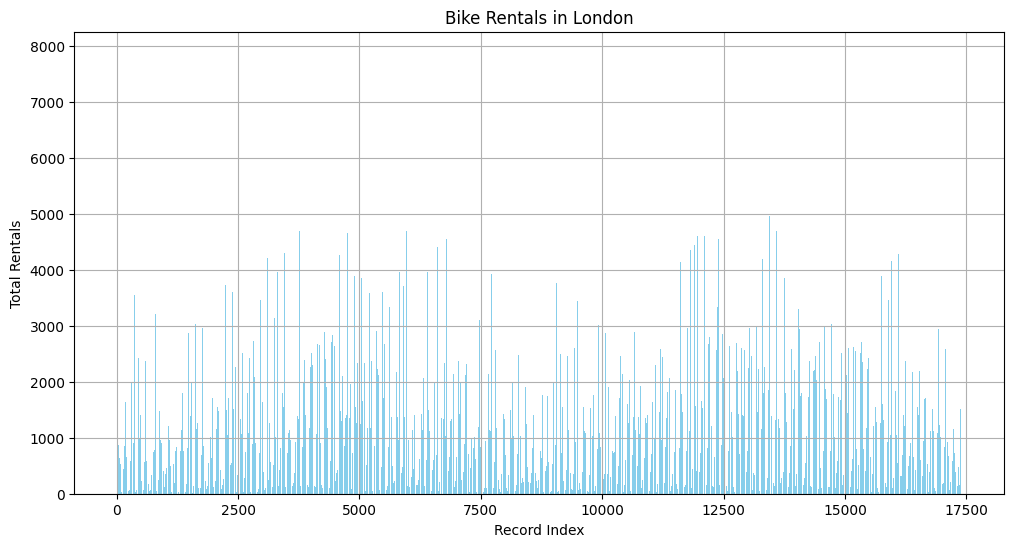

In [10]:
# 利用数の推移をプロット
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['cnt'], color='skyblue')
plt.title('Bike Rentals in London')
plt.xlabel('Record Index')
plt.ylabel('Total Rentals')
plt.grid()
plt.show()

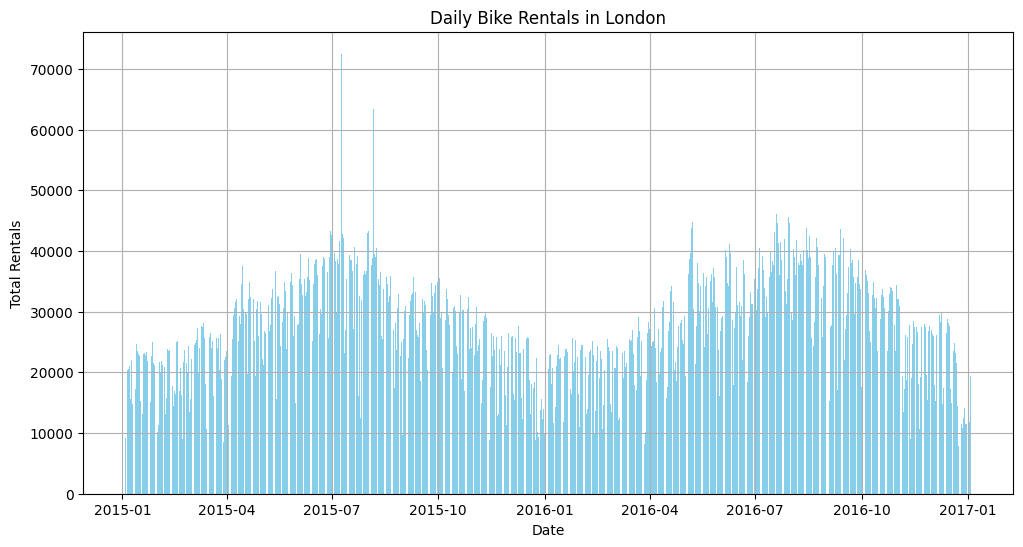

In [11]:
# 日別の利用数の推移をプロット
plt.figure(figsize=(12, 6))
df_month = df.set_index('timestamp')['cnt'].resample('D').sum()
plt.bar(df_month.index, df_month.values, color='skyblue')
plt.title('Daily Bike Rentals in London')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.grid()
plt.show()

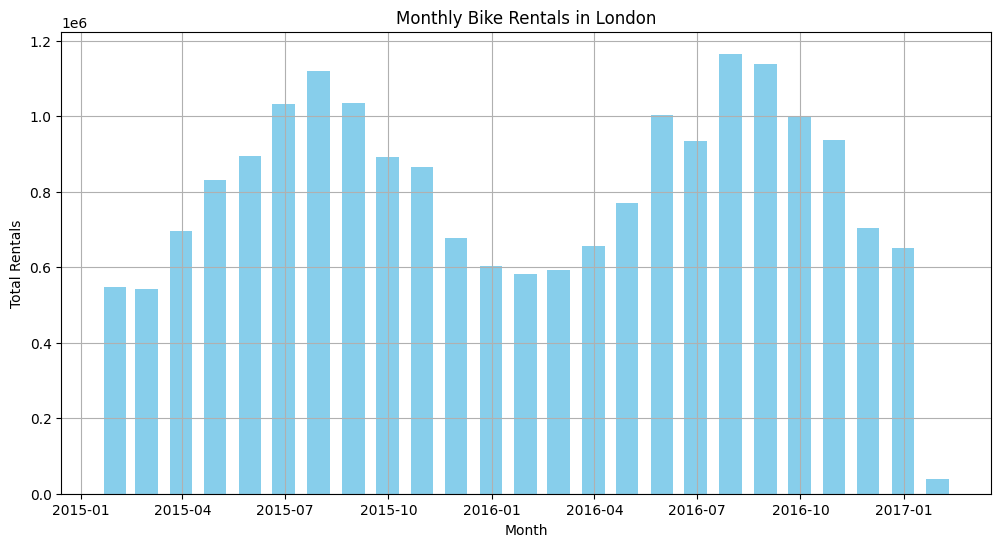

In [12]:
# 月別の利用数の推移をプロット
plt.figure(figsize=(12, 6))
df_month = df.set_index('timestamp')['cnt'].resample('ME').sum()
plt.bar(df_month.index, df_month.values, width=20, color='skyblue')
plt.title('Monthly Bike Rentals in London')
plt.xlabel('Month')
plt.ylabel('Total Rentals')
plt.grid()
plt.show()

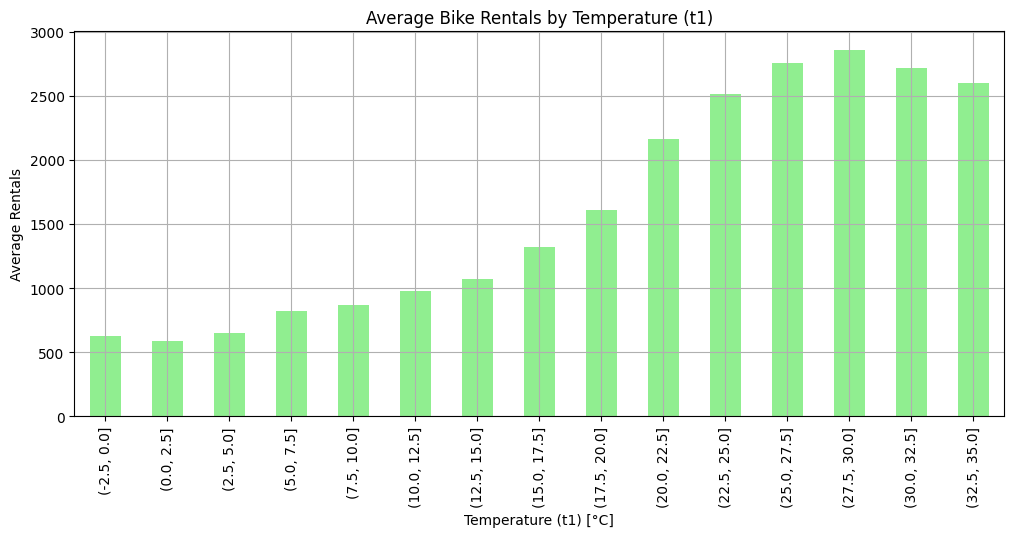

In [16]:
# 気温t1を5度ごとでcntを集計し、棒グラフで表示
plt.figure(figsize=(12, 5))
df_temp = df.groupby(pd.cut(df['t1'], bins=np.arange(-5, 40, 2.5)))['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Temperature (t1)')
plt.xlabel('Temperature (t1) [°C]')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

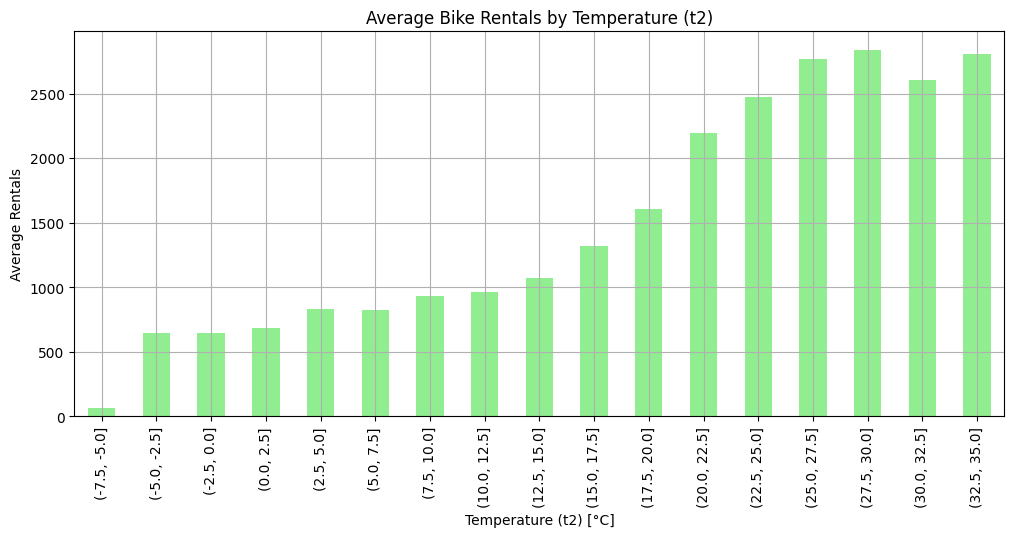

In [26]:
# 体感気温t2を5度ごとでcntを集計し、棒グラフで表示
plt.figure(figsize=(12, 5))
df_temp = df.groupby(pd.cut(df['t2'], bins=np.arange(-10, 40, 2.5)))['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Temperature (t2)')
plt.xlabel('Temperature (t2) [°C]')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

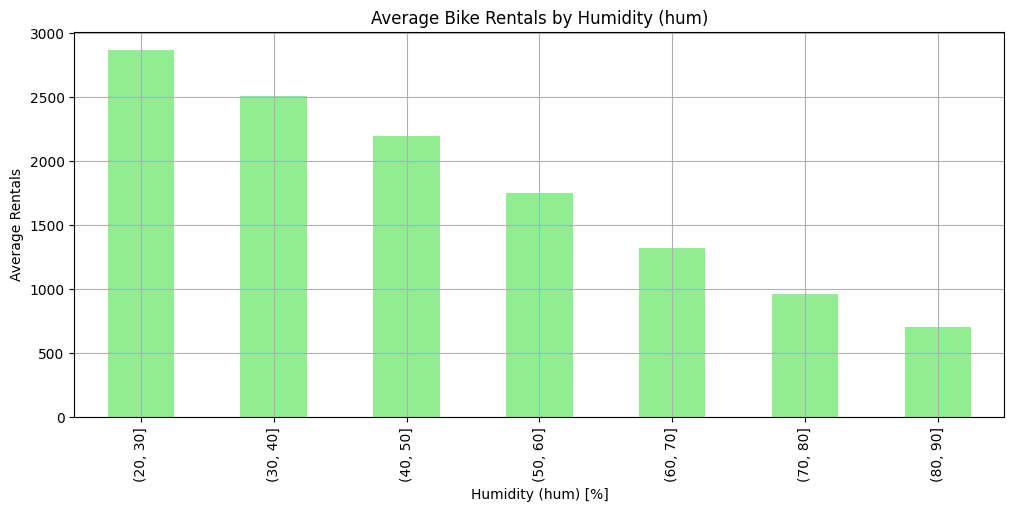

In [17]:
# 湿度humを10%ごとにcntを集計し、棒グラフで表示
plt.figure(figsize=(12, 5))
df_temp = df.groupby(pd.cut(df['hum'], bins=np.arange(0, 100, 10)))['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Humidity (hum)')
plt.xlabel('Humidity (hum) [%]')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

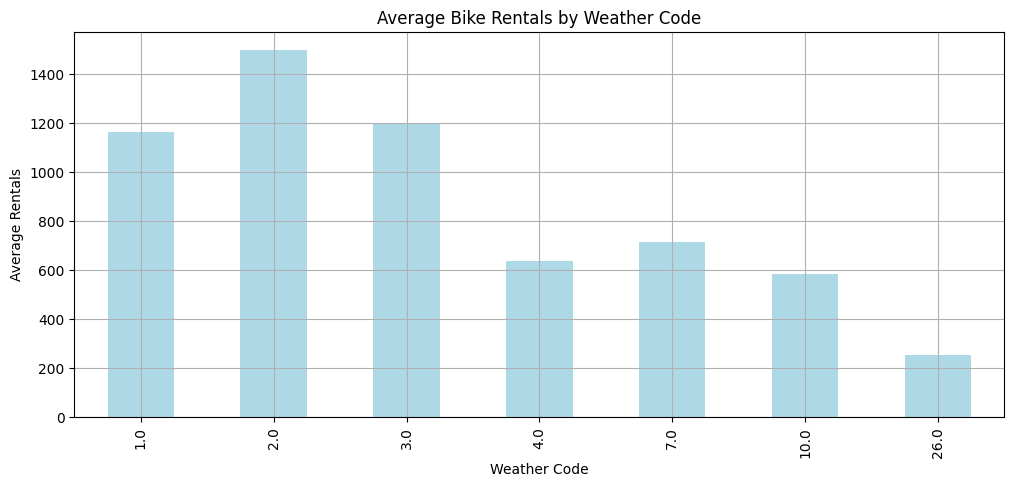

In [27]:
# weather_codeごとにcntを集計し、棒グラフで表示
# 天候コード 1=快晴 2=晴れ（雲が点在） 3=晴れ（切れ切れの雲） 4=曇り 7=雨/小雨/弱い雨 10=雷雨を伴う雨 26=降雪 94=凍結霧
plt.figure(figsize=(12, 5))
df_temp = df.groupby('weather_code')['cnt'].mean()
df_temp.plot(kind='bar', color='lightblue')
plt.title('Average Bike Rentals by Weather Code')
plt.xlabel('Weather Code')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

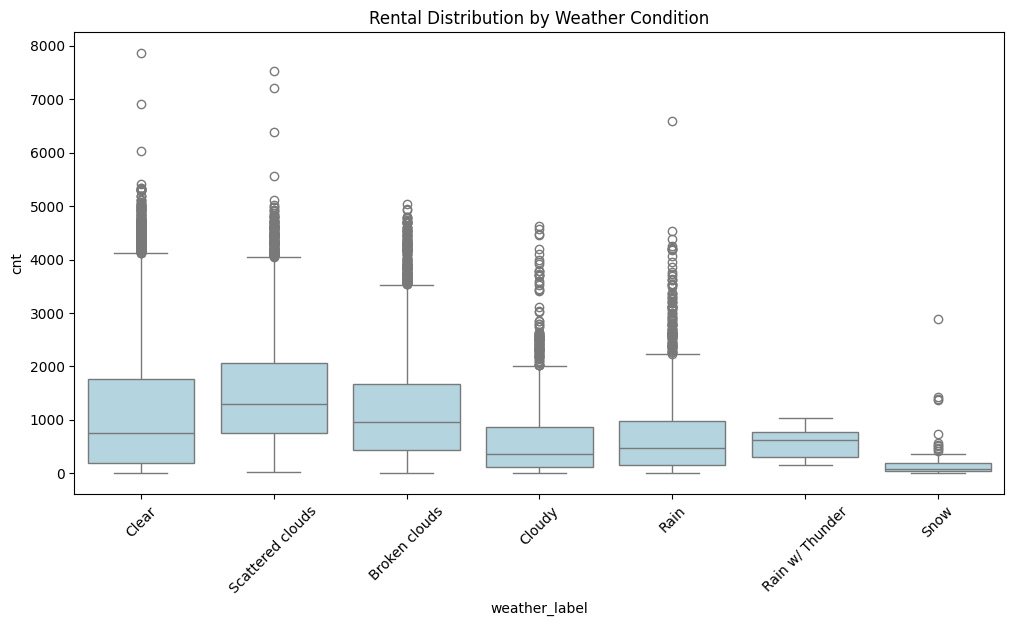

In [28]:
# 天候(weather_code)別の利用数（箱ひげ図）
# 1:晴れ, 2:少しくもり, 3:くもり, 4:どんより, 7:雨, 10:雷雨, 26:雪
weather_dict = {1:'Clear', 2:'Scattered clouds', 3:'Broken clouds', 4:'Cloudy', 7:'Rain', 10:'Rain w/ Thunder', 26:'Snow'}
df['weather_label'] = df['weather_code'].map(weather_dict)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='weather_label', y='cnt', order=list(weather_dict.values()), color='lightblue') # orderで天候の順番を指定
plt.xticks(rotation=45)
plt.title('Rental Distribution by Weather Condition')
plt.show()

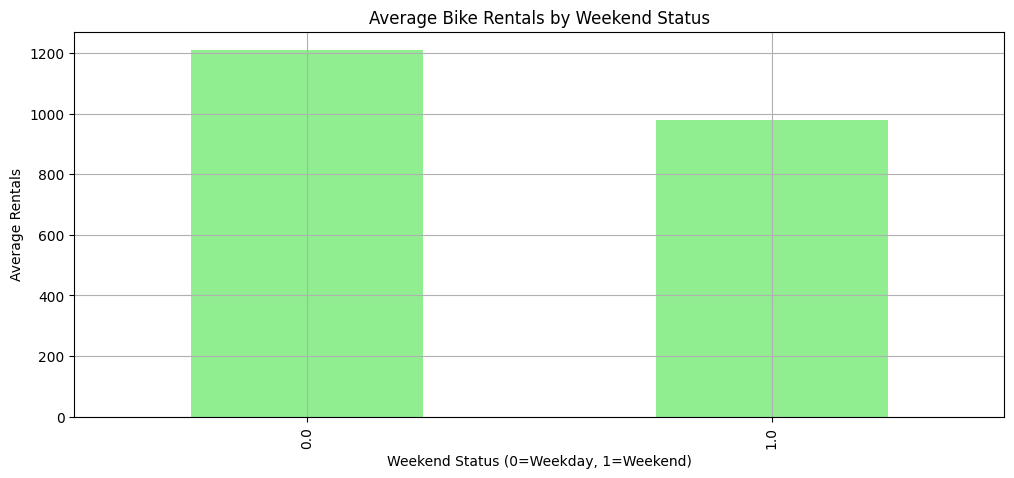

In [29]:
# is_weekendにcntを集計し、棒グラフで表示 (is_weekend 0=平日 1=週末)
plt.figure(figsize=(12, 5))
df_temp = df.groupby('is_weekend')['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Weekend Status')
plt.xlabel('Weekend Status (0=Weekday, 1=Weekend)')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

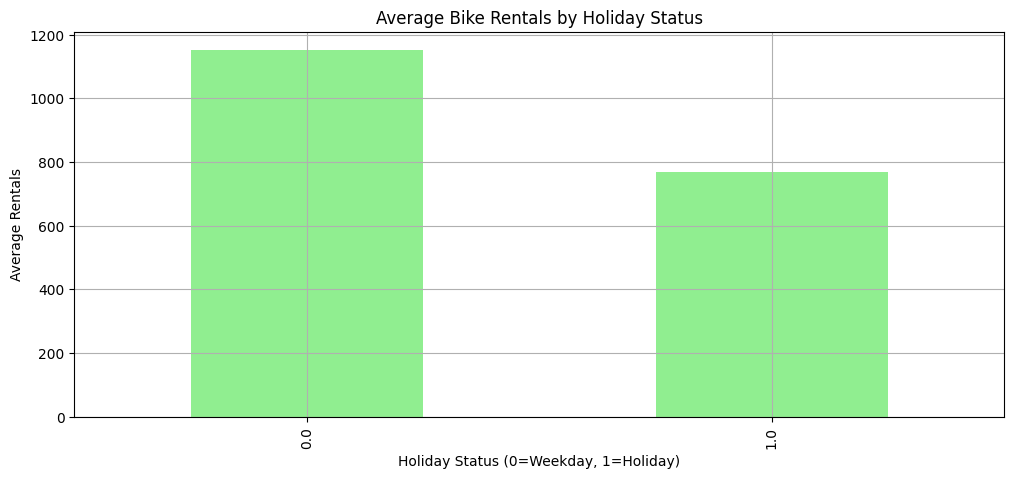

In [30]:
# is_holidayでcntを集計し、棒グラフで表示 (is_holiday 0=平日 1=祝日)
plt.figure(figsize=(12, 5))
df_temp = df.groupby('is_holiday')['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Holiday Status')
plt.xlabel('Holiday Status (0=Weekday, 1=Holiday)')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

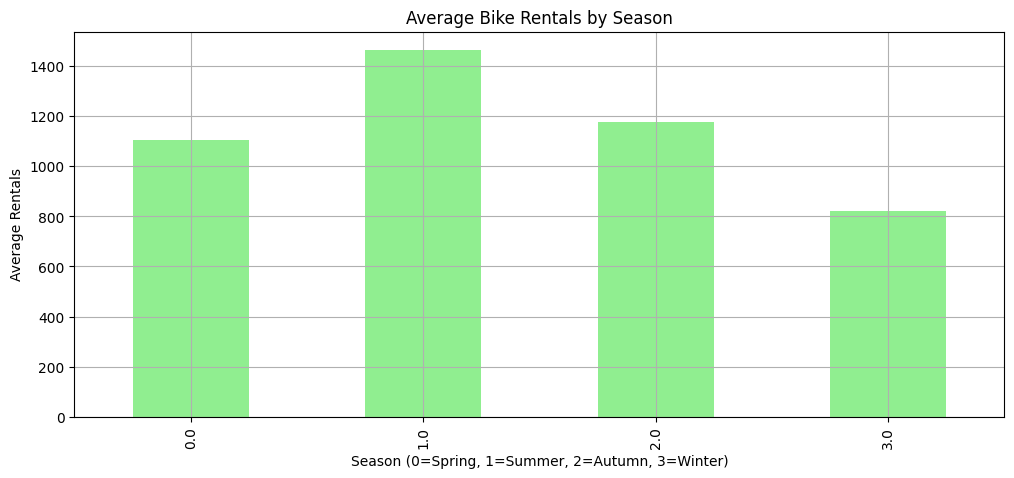

In [31]:
# seasonでcntを集計し、棒グラフで表示
# season: 0=春　1=夏　2=秋　3=冬
plt.figure(figsize=(12, 5))
df_temp = df.groupby('season')['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Season')
plt.xlabel('Season (0=Spring, 1=Summer, 2=Autumn, 3=Winter)')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

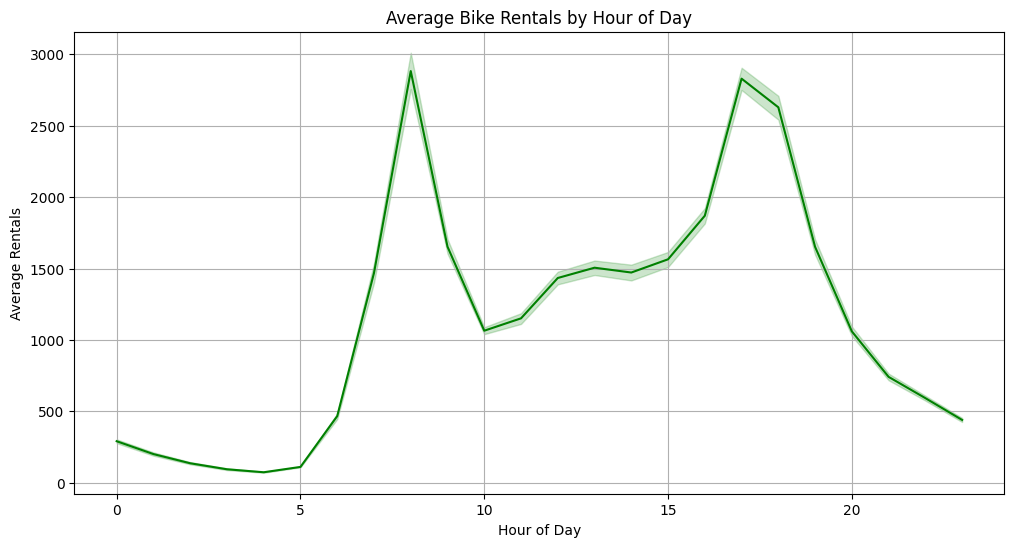

In [32]:
# 時間ごとの利用数の推移をプロット (平均値と95%信頼区間を表示)
plt.figure(figsize=(12, 6))
df_hour = df.groupby('hour')['cnt'].mean()
sns.lineplot(data=df, x='hour', y='cnt', color='green')
plt.title('Average Bike Rentals by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

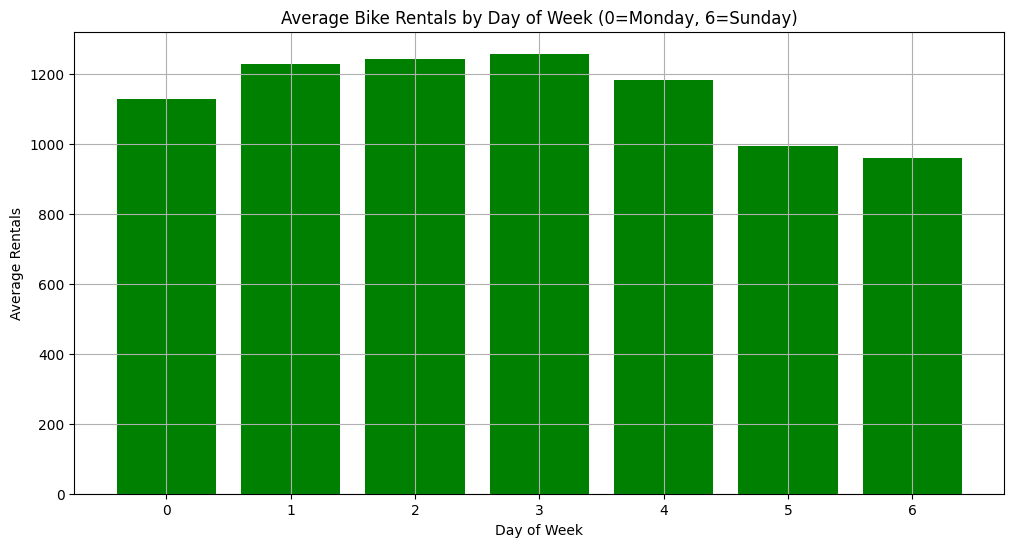

In [14]:
# 曜日ごとの利用数の推移をプロット
plt.figure(figsize=(12, 6))
df_hour = df.groupby('day_of_week')['cnt'].mean()
plt.bar(df_hour.index, df_hour.values, color='green')
plt.title('Average Bike Rentals by Day of Week (0=Monday, 6=Sunday)')
plt.xlabel('Day of Week')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

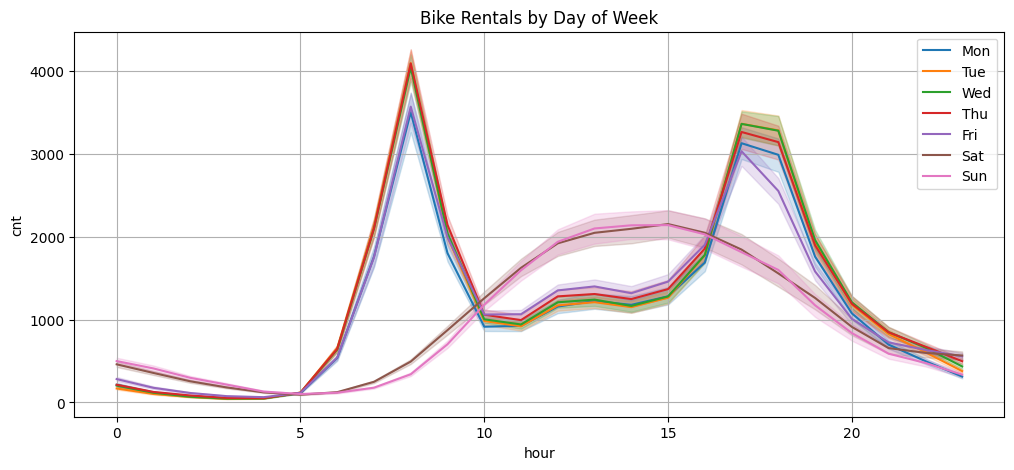

In [33]:
# 曜日ごとの利用パターンの違い (平均値と95%信頼区間を表示)
plt.figure(figsize=(12, 5))
sns.lineplot(data=df[df['day_of_week'] == 0], x='hour', y='cnt', label='Mon')
sns.lineplot(data=df[df['day_of_week'] == 1], x='hour', y='cnt', label='Tue')
sns.lineplot(data=df[df['day_of_week'] == 2], x='hour', y='cnt', label='Wed')
sns.lineplot(data=df[df['day_of_week'] == 3], x='hour', y='cnt', label='Thu')
sns.lineplot(data=df[df['day_of_week'] == 4], x='hour', y='cnt', label='Fri')
sns.lineplot(data=df[df['day_of_week'] == 5], x='hour', y='cnt', label='Sat')
sns.lineplot(data=df[df['day_of_week'] == 6], x='hour', y='cnt', label='Sun')
plt.title('Bike Rentals by Day of Week')
plt.grid(True)
plt.show()

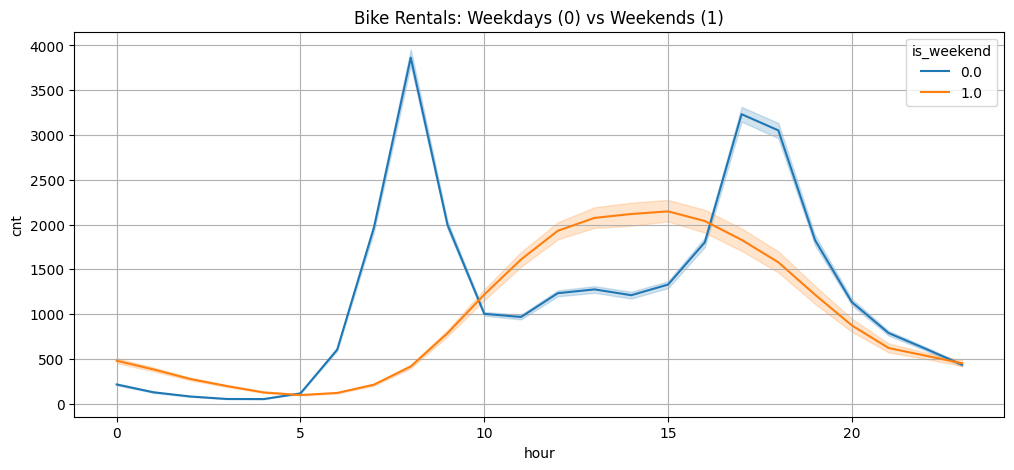

In [34]:
# 平日と休日の利用パターンの違い (平均値と95%信頼区間を表示)
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='hour', y='cnt', hue='is_weekend')
plt.title('Bike Rentals: Weekdays (0) vs Weekends (1)')
plt.grid(True)
plt.show()

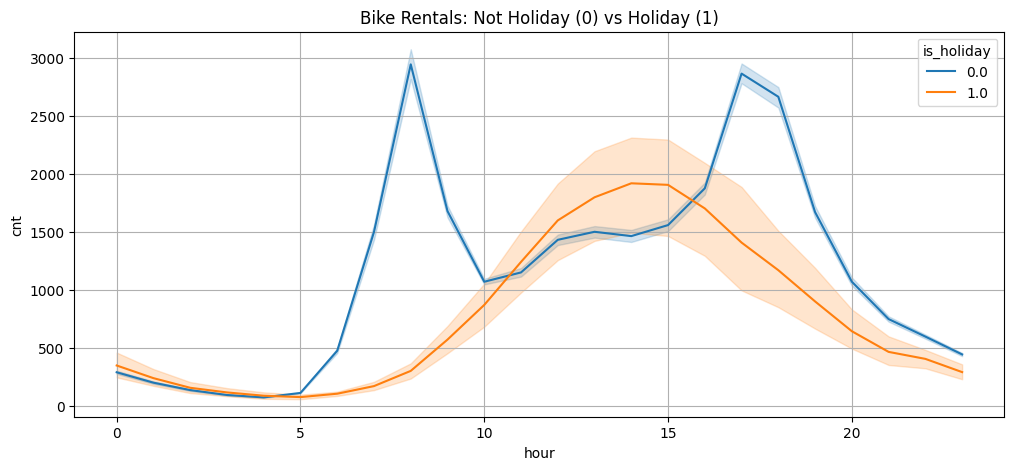

In [35]:
# 祝日の利用パターン (平均値と95%信頼区間を表示)
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='hour', y='cnt', hue='is_holiday')
plt.title('Bike Rentals: Not Holiday (0) vs Holiday (1)')
plt.grid(True)
plt.show()

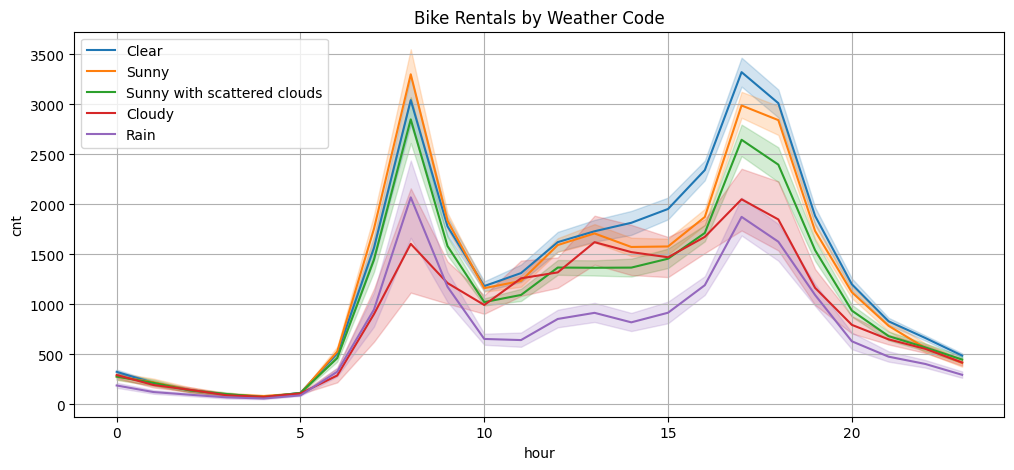

In [ ]:
# weather_codeごとの利用パターンの違い
plt.figure(figsize=(12, 5))
sns.lineplot(data=df[df['weather_code'] == 1], x='hour', y='cnt', label='Clear')
sns.lineplot(data=df[df['weather_code'] == 2], x='hour', y='cnt', label='Sunny')
sns.lineplot(data=df[df['weather_code'] == 3], x='hour', y='cnt', label='Sunny with scattered clouds')
sns.lineplot(data=df[df['weather_code'] == 4], x='hour', y='cnt', label='Cloudy')
sns.lineplot(data=df[df['weather_code'] == 7], x='hour', y='cnt', label='Rain')
# sns.lineplot(data=df[df['weather_code'] == 10], x='hour', y='cnt', label='Thunderstorm')
# sns.lineplot(data=df[df['weather_code'] == 26], x='hour', y='cnt', label='Snow')
plt.title('Bike Rentals by Weather Code')
plt.grid(True)
plt.show()

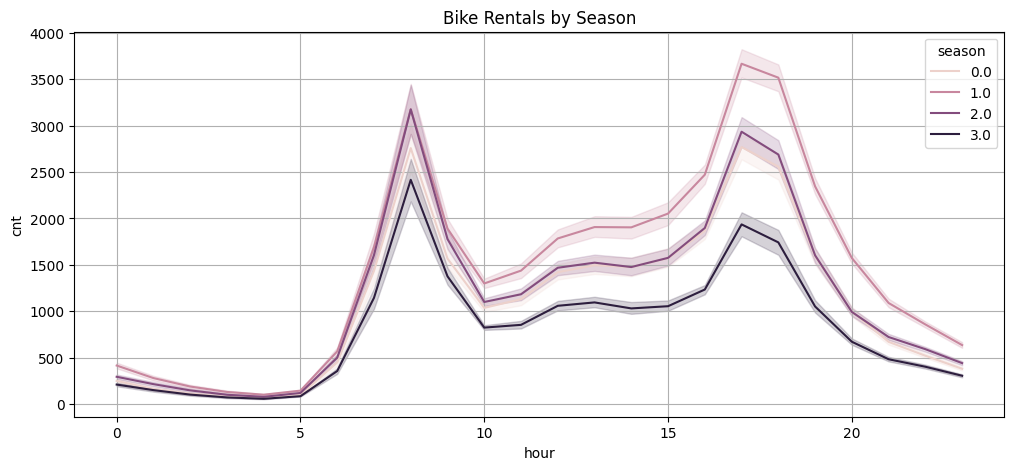

In [25]:
# 季節ごとの利用パターン
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='hour', y='cnt', hue='season')
plt.title('Bike Rentals by Season')
plt.grid(True)
plt.show()

### 特定条件下での平均利用数 ###
特定条件下での平均利用数: 324.7
全体の平均利用数: 1143.1


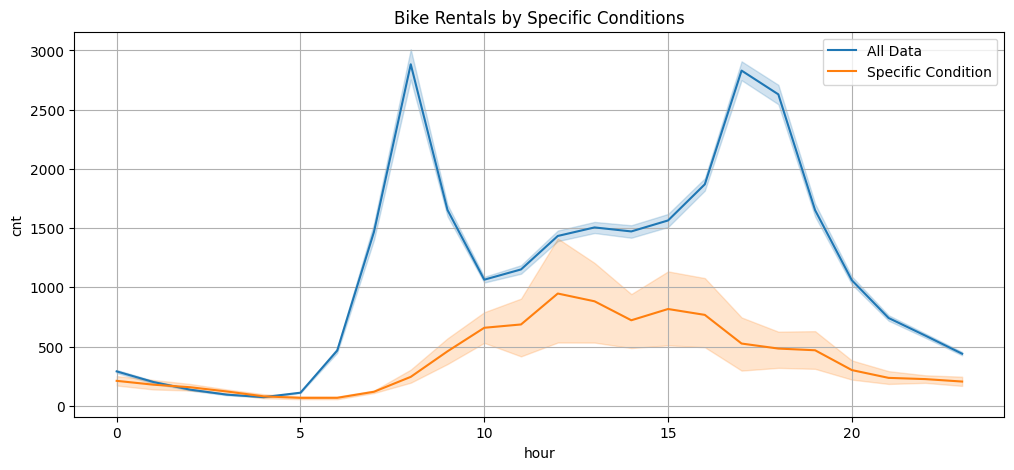

In [36]:
# 経験則からのルール作成  例：気温が10度以下、雨、かつ週末の時の平均利用数
print("### 特定条件下での平均利用数 ###")
df_specific_condition = df[(df['t1'] < 10) & (df['weather_code'] >= 7) & (df['is_weekend'] == 1)]
print(f"特定条件下での平均利用数: {df_specific_condition['cnt'].mean():.1f}")
print(f"全体の平均利用数: {df['cnt'].mean():.1f}")

# 特定条件下の利用数の推移をプロット
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='hour', y='cnt', label='All Data')
sns.lineplot(data=df_specific_condition, x='hour', y='cnt', label='Specific Condition')
plt.title('Bike Rentals by Specific Conditions')
plt.grid(True)
plt.show()

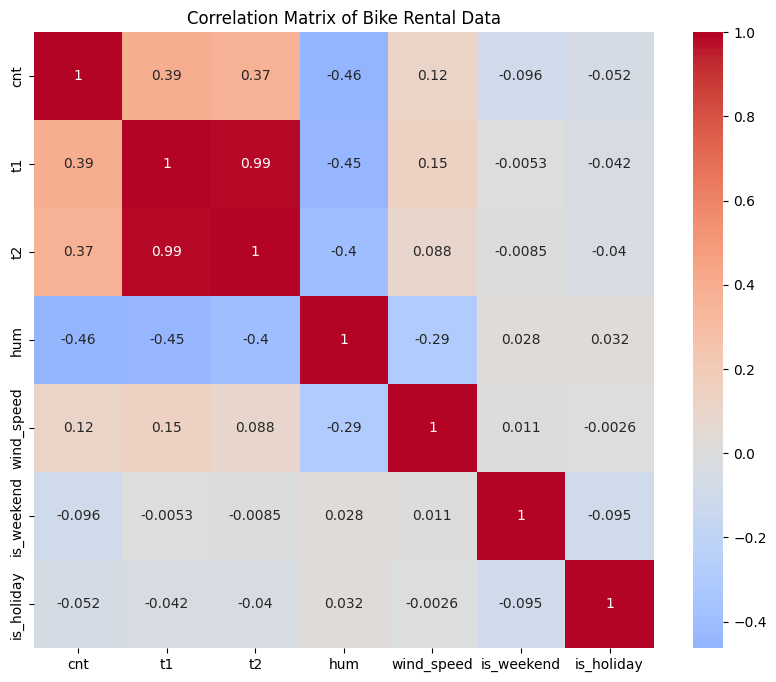

In [38]:
# データの相関行列を作成して、ヒートマップで表示
corr_matrix = df[['cnt', 't1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Bike Rental Data')
plt.show()

In [64]:
# 利用数を予測するための線形モデルを作成し、精度を検証
df_tmp = df.copy()
# df_tmp = df.query(f'hour == 8')

# dfを学習用とテスト用に分割
# 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）を使用
X = df_tmp[['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday']]
y = df_tmp['cnt'] # 目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 線形回帰モデルを作成、学習
model = LinearRegression()
model.fit(X_train, y_train)

# テストデータで予測
y_pred = model.predict(X_test)

# 各種評価指標を計算
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'All Hours: Mean Absolute Error: {mae:.2f} Mean Squared Error: {mse:.2f} R2 Score: {r2:.2f}')

# 予測値と実際の値を比較するグラフを作成
# timestamp (サンプルの日時)、y_test（実際の値）と y_pred（モデルの予測値）をDataFrameにまとめる
results_df = pd.DataFrame({
    'timestamp': df.loc[y_test.index, 'timestamp'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Plotly Expressで散布図を作成
fig = px.scatter(
    results_df, 
    x='Actual', 
    y='Predicted',
    hover_data=['timestamp'],
    labels={'timestamp': '日時', 'Actual': '実際の利用数', 'Predicted': 'モデルの予測数'},
    title='Actual vs. Predicted (Bike Rentals)',
    opacity=0.6,
    template='plotly_white'
)

# 理想線 (y = x) の追加 (予測が完璧なら、すべての点がこの直線上に並びます)
max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
fig.add_shape(
    type='line', x0=min_val, y0=min_val, x1=max_val, y1=max_val,
    line=dict(color='Red', dash='dash'), layer='below'
)

# グラフのレイアウト調整（正方形に近くすると比較しやすい）
fig.update_layout(
    width=700,
    height=700,
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(constrain='domain')
)
fig.show()

All Hours: Mean Absolute Error: 700.36 Mean Squared Error: 899650.14 R2 Score: 0.25


In [65]:
# 各時刻の利用数を予測するための線形モデルを作成し、精度を検証
for _hour in range(24):
    # _hourのデータを抽出
    df_tmp = df.query(f'hour == {_hour}')

    # dfを学習用とテスト用に分割
    # 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）を使用
    features = ['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday']
    X = df_tmp[features]
    y = df_tmp['cnt'] # 目的変数
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 線形回帰モデルを作成
    model = LinearRegression()
    model.fit(X_train, y_train)
    # テストデータで予測
    y_pred = model.predict(X_test)
    # 各種評価指標を計算
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{_hour}: Mean Absolute Error: {mae:.2f} Mean Squared Error: {mse:.2f} R2 Score: {r2:.2f}')

0: Mean Absolute Error: 70.29 Mean Squared Error: 9879.14 R2 Score: 0.70
1: Mean Absolute Error: 58.74 Mean Squared Error: 7720.36 R2 Score: 0.68
2: Mean Absolute Error: 32.82 Mean Squared Error: 2039.89 R2 Score: 0.79
3: Mean Absolute Error: 24.78 Mean Squared Error: 1227.57 R2 Score: 0.79
4: Mean Absolute Error: 17.44 Mean Squared Error: 615.20 R2 Score: 0.68
5: Mean Absolute Error: 17.47 Mean Squared Error: 753.39 R2 Score: 0.46
6: Mean Absolute Error: 72.62 Mean Squared Error: 15429.43 R2 Score: 0.80
7: Mean Absolute Error: 194.52 Mean Squared Error: 76945.85 R2 Score: 0.91
8: Mean Absolute Error: 358.25 Mean Squared Error: 339464.64 R2 Score: 0.90
9: Mean Absolute Error: 194.24 Mean Squared Error: 78395.79 R2 Score: 0.84
10: Mean Absolute Error: 152.28 Mean Squared Error: 50504.21 R2 Score: 0.54
11: Mean Absolute Error: 214.27 Mean Squared Error: 87766.76 R2 Score: 0.68
12: Mean Absolute Error: 287.86 Mean Squared Error: 148320.94 R2 Score: 0.65
13: Mean Absolute Error: 309.85 Mea

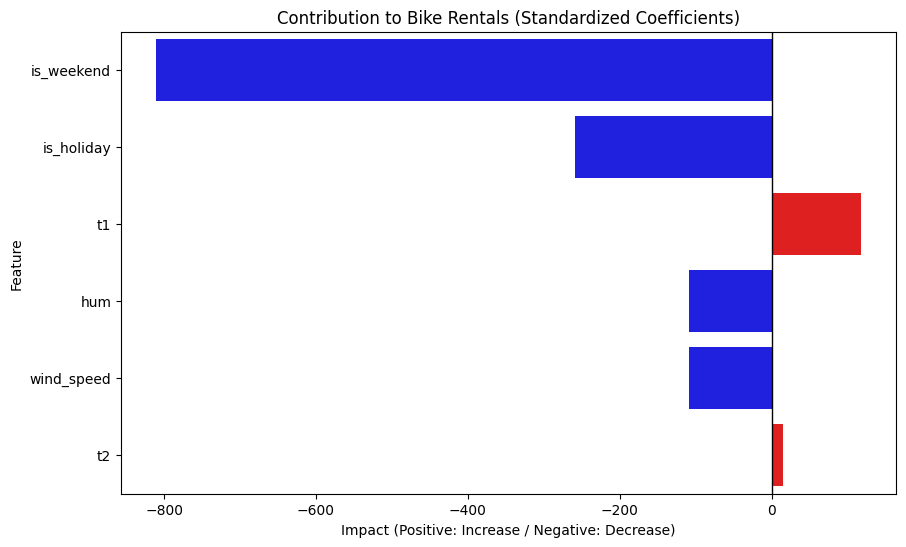

寄与度の詳細:


,Feature,Coefficient
4,is_weekend,-810.304120
5,is_holiday,-259.545291
0,t1,117.243062
2,hum,-109.154756
3,wind_speed,-108.707530
1,t2,15.130895


In [66]:
# 最も予測精度が高かった7時のモデルにおいて、特徴量の寄与度を確認
_hour = 7
# _hourのデータを抽出
df_tmp = df.query(f'hour == {_hour}')

# dfを学習用とテスト用に分割
# 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）を使用
features = ['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday']
X = df_tmp[features]
y = df_tmp['cnt'] # 目的変数

# データの標準化 (寄与度を正しく比較するため)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 線形回帰モデルを作成、学習
model = LinearRegression()
model.fit(X_scaled, y)

# 寄与度（回帰係数）の抽出
# 標準化されたデータに対する係数は「標準化係数」と呼ばれ、絶対値が大きいほど影響力が強いことを示します
contribution = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})

# 寄与度の絶対値でソート
contribution['Abs_Coefficient'] = contribution['Coefficient'].abs()
contribution = contribution.sort_values(by='Abs_Coefficient', ascending=False)

# 寄与度を可視化
plt.figure(figsize=(10, 6))
colors = ['red' if x > 0 else 'blue' for x in contribution['Coefficient']]
sns.barplot(data=contribution, x='Coefficient', y='Feature', palette=colors, hue='Feature', legend=False)
plt.title('Contribution to Bike Rentals (Standardized Coefficients)')
plt.axvline(0, color='black', linewidth=1)
plt.xlabel('Impact (Positive: Increase / Negative: Decrease)')
plt.show()

print("寄与度の詳細:")
display(contribution[['Feature', 'Coefficient']])

All Hours: Mean Absolute Error: 129.31 Mean Squared Error: 56341.46 R2 Score: 0.95


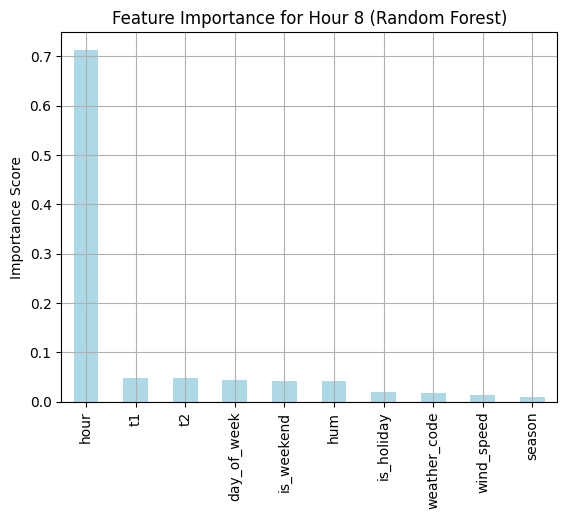

In [ ]:
# 最も予測精度が高かった7時のモデルにおいて、特徴量の重要度を確認
# _hour = 8
# # _hourのデータを抽出
# df_tmp = df.query(f'hour == {_hour}')

# 利用数を予測するための非線形モデルを作成し、精度を検証
df_tmp = df.copy()

# dfを学習用とテスト用に分割
# 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）
# weather_code, season, hour, day_of_week を使用
features = ['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday', 'weather_code', 'season', 'hour', 'day_of_week']
X = df_tmp[features]
y = df_tmp['cnt'] # 目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 非線形モデルを作成
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# テストデータで予測
y_pred = model.predict(X_test)

# 各種評価指標を計算
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'All Hours: Mean Absolute Error: {mae:.2f} Mean Squared Error: {mse:.2f} R2 Score: {r2:.2f}')

# 特徴量の重要度を表示
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', color='lightblue')
plt.title('Feature Importance for Hour 8 (Random Forest)')
plt.ylabel('Importance Score')
plt.grid()
plt.show()

In [54]:
# 「現場の知恵」を特徴量として追加
# ルール1：通勤ラッシュの時間帯か？
df['is_rush_hour'] = df['hour'].apply(lambda x: 1 if x in [7,8,9,17,18,19] else 0)
# ルール2：サイクリングに最適な気温（例：15度〜25度）か？
df['is_pleasant_temp'] = df['t1'].apply(lambda x: 1 if 15 <= x <= 25 else 0)

features: ['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday', 'weather_code', 'season', 'hour', 'day_of_week', 'is_rush_hour', 'is_pleasant_temp']
All Hours: Mean Absolute Error: 130.90 Mean Squared Error: 58787.39 R2 Score: 0.95


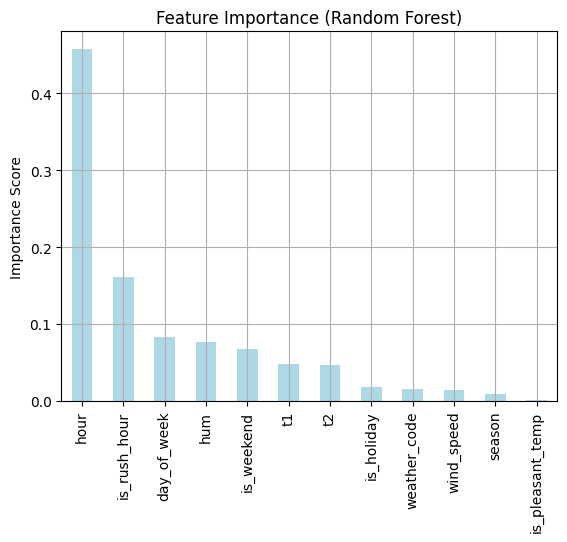

In [67]:
# 全時刻のデータを利用して、非線形モデルを作成し、特徴量の重要度を確認
df_tmp = df.copy()

# dfを学習用とテスト用に分割
# 特徴量に現場の知恵を追加
features = ['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday', 'weather_code', 'season', 
            'hour', 'day_of_week', 'is_rush_hour', 'is_pleasant_temp']
X = df_tmp[features]
y = df['cnt'] # 目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 非線形モデルを作成
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# テストデータで予測
y_pred = model.predict(X_test)

# 各種評価指標を計算
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('features:', X.columns.tolist())
print(f'All Hours: Mean Absolute Error: {mae:.2f} Mean Squared Error: {mse:.2f} R2 Score: {r2:.2f}')

# 予測値と実際の値を比較するグラフを作成
# 評価用データの作成
# timestamp (サンプルの日時)、y_test（実際の値）と y_pred（モデルの予測値）をDataFrameにまとめる
results_df = pd.DataFrame({
    'timestamp': df.loc[y_test.index, 'timestamp'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Plotly Expressで散布図を作成
fig = px.scatter(
    results_df, 
    x='Actual', 
    y='Predicted',
    hover_data=['timestamp'],
    labels={'timestamp': '日時', 'Actual': '実際の利用数', 'Predicted': 'モデルの予測数'},
    title='Actual vs. Predicted (Bike Rentals)',
    opacity=0.6,
    template='plotly_white'
)

# 理想線 (y = x) の追加
# 予測が完璧なら、すべての点はのこの直線上に並びます
max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())

fig.add_shape(
    type='line',
    x0=min_val, y0=min_val,
    x1=max_val, y1=max_val,
    line=dict(color='Red', dash='dash'),
    layer='below'
)

# 4. グラフのレイアウト調整（正方形に近くすると比較しやすい）
fig.update_layout(
    width=700,
    height=700,
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(constrain='domain')
)

fig.show()

# 特徴量の重要度を表示
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', color='lightblue')
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance Score')
plt.grid()
plt.show()

In [63]:
# 誤差の計算とデータの統合
# インデックスをキーにして、予測結果と元の特徴量を結合します
error_analysis_df = pd.DataFrame({
    'timestamp': df.loc[y_test.index, 'timestamp'],
    'Actual': y_test,
    'Predicted': y_pred.round(1), # 見やすくするために四捨五入
    'Error': (y_test - y_pred).round(1)
})

# 元のデータからコンテキスト情報（天気や気温など）を結合
context_features = ['t1', 'hum', 'weather_label', 'is_holiday', 'is_weekend']
error_analysis_df = error_analysis_df.join(df.loc[y_test.index, context_features])

# 誤差(過大)（ワースト5）にソート
worst_5 = error_analysis_df.sort_values(by='Error', ascending=False).head(5)
print("### 予測外れ (過大) ###")
display(worst_5)
worst_5 = error_analysis_df.sort_values(by='Error', ascending=True).head(5)
print("### 予測外れ (過小) ###")
display(worst_5)

### 予測外れ (過大) ###


,timestamp,Actual,Predicted,Error,t1,hum,weather_label,is_holiday,is_weekend
4461,2015-07-09 08:00:00,7531,4365.2,3165.8,14.5,61.0,Scattered clouds,0.0,0.0
5129,2015-08-06 08:00:00,6585,3568.5,3016.5,19.0,78.0,Rain,0.0,0.0
5139,2015-08-06 18:00:00,6394,4270.2,2123.8,21.5,58.5,Scattered clouds,0.0,0.0
5140,2015-08-06 19:00:00,4384,2648.2,1735.8,20.0,62.0,Clear,0.0,0.0
2216,2015-04-06 16:00:00,2723,1179.9,1543.1,10.5,76.5,Broken clouds,1.0,0.0


### 予測外れ (過小) ###


,timestamp,Actual,Predicted,Error,t1,hum,weather_label,is_holiday,is_weekend
6248,2015-09-22 08:00:00,1587,4558.0,-2971.0,12.0,88.0,Broken clouds,0.0,0.0
8603,2015-12-30 08:00:00,958,3074.7,-2116.7,14.0,59.0,Clear,0.0,0.0
3298,2015-05-21 18:00:00,3764,5459.0,-1695.0,19.5,27.0,Clear,0.0,0.0
103,2015-01-08 08:00:00,1228,2805.5,-1577.5,9.5,87.5,Rain,0.0,0.0
1710,2015-03-16 08:00:00,1984,3547.2,-1563.2,6.5,90.0,Broken clouds,0.0,0.0


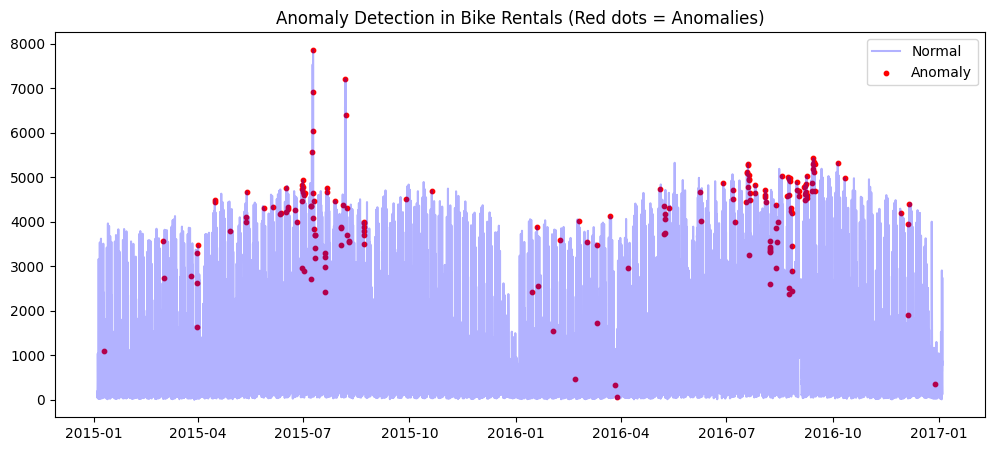

In [ ]:
# 異常検知 (Isolation Forest)
# 「通常ではありえない利用パターン」を自動で検出
features_iso = ['cnt', 't1', 'hum', 'wind_speed', 'hour', 'is_rush_hour']
iso_model = IsolationForest(contamination=0.01, random_state=42) # 上位1%を異常とする
df['anomaly'] = iso_model.fit_predict(df[features_iso])

# 異常値の可視化 (-1が異常)
anomalies = df[df['anomaly'] == -1]
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['cnt'], color='blue', label='Normal', alpha=0.3)
plt.scatter(anomalies['timestamp'], anomalies['cnt'], color='red', label='Anomaly', s=10)
plt.title('Anomaly Detection in Bike Rentals (Red dots = Anomalies)')
plt.legend()
plt.show()